<a href="https://colab.research.google.com/github/sokanaid/CourseProject2022BiologicalMath/blob/main/find_plateau_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорты, подключение библиотек

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/sim_tables

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/sim_tables'
/content


# Подбор момента выхода на плато

## Чтение данных

In [7]:
def read_csv_file(directory_path, name):
  file_path = os.path.join(directory_path, name + ".csv")
  return pd.read_csv(file_path)

In [11]:
#def read_description(directory_path, file_name = "description.txt"):
  file_path = os.path.join(directory_path, file_name)
  print("read description from file  ", file_path)
  with open(file_path, 'r') as file:
    return file.read()

IndentationError: ignored

In [27]:
def read_files(directory_path):
  datas = []
  for folder_name in os.listdir(directory_path):
      folder_path = os.path.join(directory_path, folder_name)
      data = {}
      data["population"] = read_csv_file(folder_path, "population")
      data["population"].drop(data["population"].tail(1).index, inplace=True)
      data["population"].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
      data["smoothed"] = read_csv_file(folder_path, 'smoothed')
      data["smoothed"].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
      datas.append(data)
  return datas

In [25]:
def read_file(directory_path, file_type):
  data = {}
  data["population"] = read_csv_file(directory_path, file_type)
  data["population"].drop(data["population"].tail(1).index, inplace=True)
  data["population"].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
  return data

## Построение графиков

In [24]:
def print_smoothing_in_one_window(print_data1, x, x_name="epochs", start_end = None, title = None, legend1 = "population", legend2 = "smoothing"):
  fig = plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.title(title or "Smoothing")
  fig.tight_layout(pad=6.0,  h_pad=3, w_pad=3)
  fig.patch.set_visible(False)
  columns_count = 2
  axes = fig.subplots(1)

  axes.plot(x, print_data1, "b", label=legend1)
  #axes.plot(x, print_data2, "r", label=legend2)
  axes.legend(loc="lower right")
  axes.set_xlabel(x_name)
  axes.set_ylabel('pop')


In [19]:
def print_all_in_one_frame(Data, x="time", y = "population", limit = 25000):
  limit = min(limit, len(Data[0][y]))
  type_d = "pop"
  fig = plt.figure(figsize=(40, 5), dpi=80)
  plt.axis('off')
  plt.title("Simulations" )
  fig.patch.set_visible(False)
  axes = fig.subplots(nrows=1, ncols=1)
  for i, data_ in enumerate(Data):
    axes.plot(data_[y][x][:limit], data_[y][type_d][:limit], label="#"+str(i))
    axes.set_xlabel(x)
    axes.set_ylabel(y)
  axes.legend(loc="lower right")


## Загрузка симуляций, не вышедших на плато

In [28]:
data = read_files("/content/drive/MyDrive/simulations/false_plato/")

In [29]:
print(data[0]['smoothed'])

      epochs         time        pop
0          1     0.000000   1.000000
1          2     4.530756   1.000729
2          3    13.176906   1.003791
3          4    15.193551   1.012750
4          5    17.683059   1.034334
...      ...          ...        ...
2856    2857  5866.509151  31.980958
2857    2858  5868.526513  32.159735
2858    2859  5870.509125  32.458402
2859    2860  5871.892672  32.869618
2860    2861  5873.626453  33.375465

[2861 rows x 3 columns]


In [30]:
print(data[0]['population'])

      epochs         time  pop
0          1     0.000000    1
1          2     4.530756    2
2          3    13.176906    2
3          4    15.193551    4
4          5    17.683059    6
...      ...          ...  ...
2856    2857  5866.509151   48
2857    2858  5868.526513   44
2858    2859  5870.509125   38
2859    2860  5871.892672   44
2860    2861  5873.626453   38

[2861 rows x 3 columns]


Графики без сглаживания

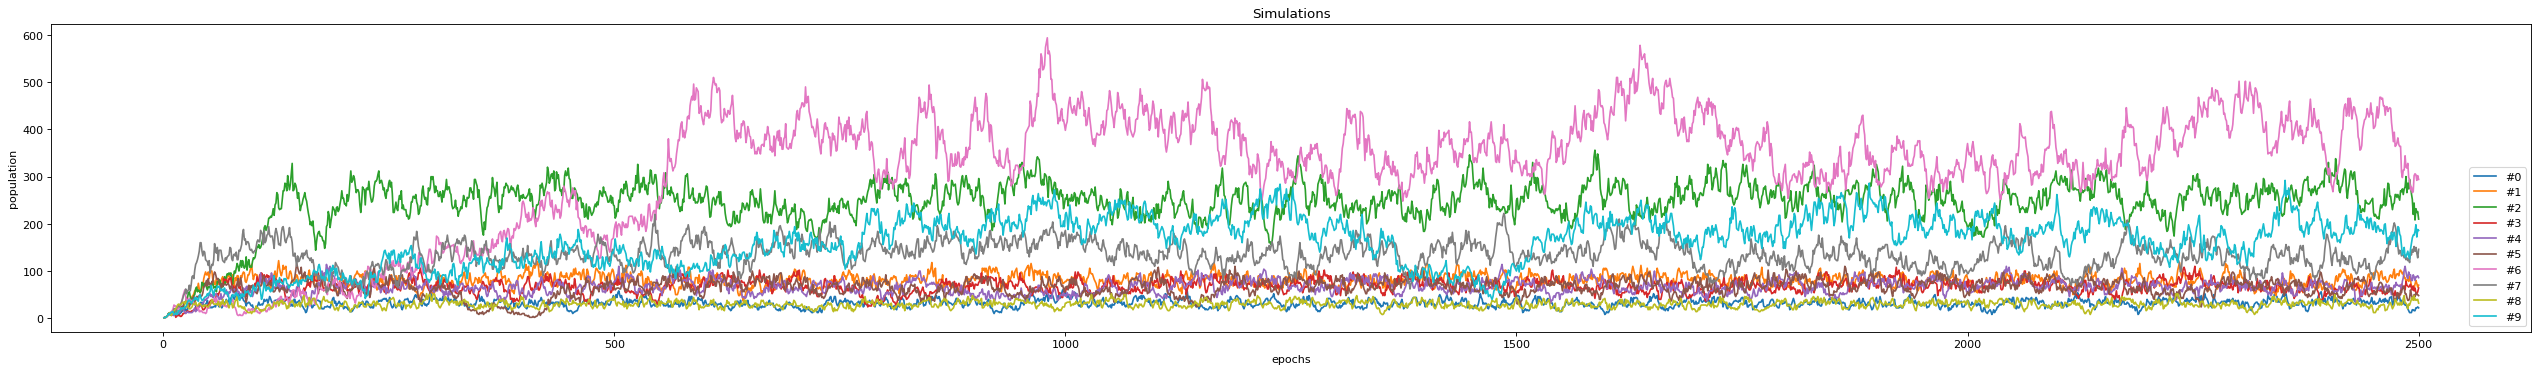

In [31]:
print_all_in_one_frame(data[:10], x = "epochs", limit = 2500)

Графики со сглаживанием

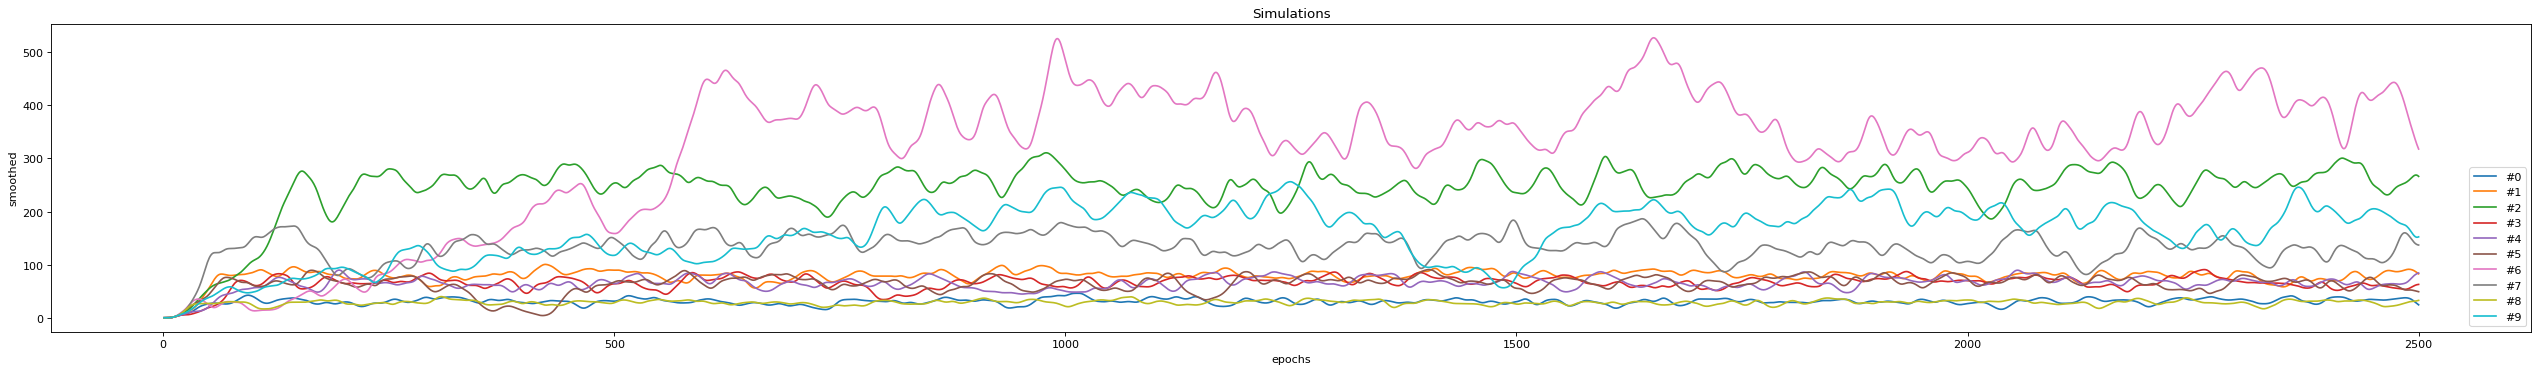

In [32]:
print_all_in_one_frame(data[:10], x = "epochs", y="smoothed", limit = 2500)

## Подбор окна сглаживания

In [33]:
def simple_exponential_smoothing(series, alpha):
  smoothing_data = series[:1]
  for i in range(1 , len(series)):
    y_i =  alpha*series[i] + smoothing_data[i-1]*(1-alpha)
    smoothing_data = pd.concat([smoothing_data, pd.Series(y_i)], ignore_index=True)
  return smoothing_data

In [34]:
def multiple_exponential_smoothing(series, alphas):
    """
    Применение простого экспоненциального сглаживания несколько раз
    
    Аргументы:
        - series: список или массив значений временного ряда
        - alphas: список коэффициентов сглаживания (0 < alpha < 1) для каждой итерации
    
    Возвращает:
        - smoothed_series: список сглаженных значений временного ряда после каждой итерации
    """
    smoothed_series = []
    current_series = series.copy()
    
    for alpha in alphas:
        current_series = simple_exponential_smoothing(current_series, alpha)
        smoothed_series.append(current_series)
    
    return smoothed_series[5]


In [62]:
data2 = read_file("/content/drive/MyDrive/simulations/smoothing/4", "population")

In [63]:
time = data2["population"]["time"]
population = data2["population"]["pop"]

In [67]:
smoothed = multiple_exponential_smoothing(population, [0.3]*10)

In [68]:
import csv

file_name = "smoothed.csv"
file_path = f"/content/drive/MyDrive/simulations/smoothing/4/{file_name}"

with open(file_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["time", "smoothed"])
    for t, s in zip(time, smoothed):
        writer.writerow([t, s])

In [69]:
data_s = read_file("/content/drive/MyDrive/simulations/smoothing/4/", "smoothed")

In [70]:
time = data_s["population"]["time"]
population_smoothed = data_s["population"]["smoothed"]

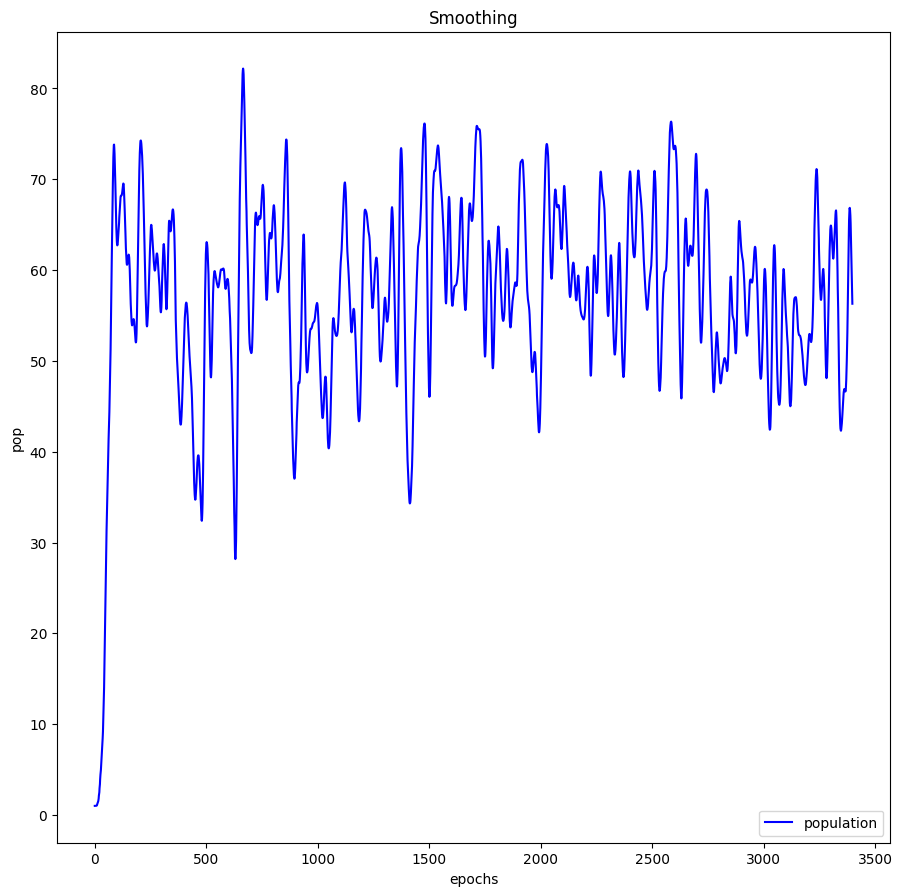

In [71]:
print_smoothing_in_one_window(population_smoothed, time)

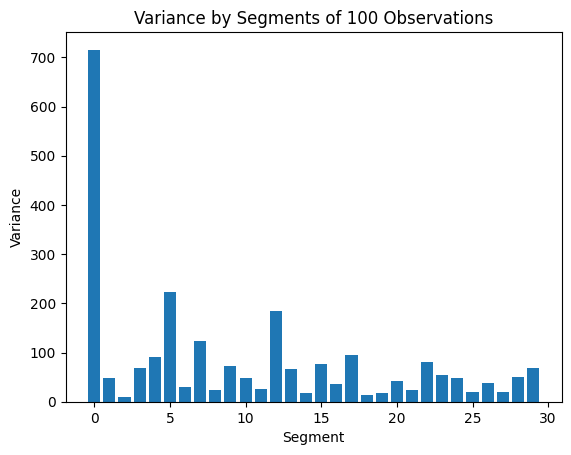

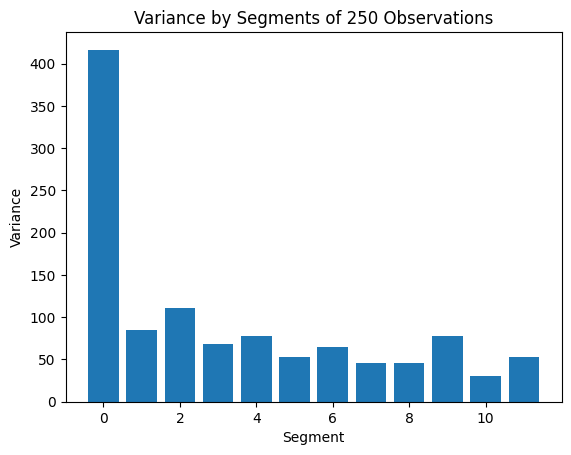

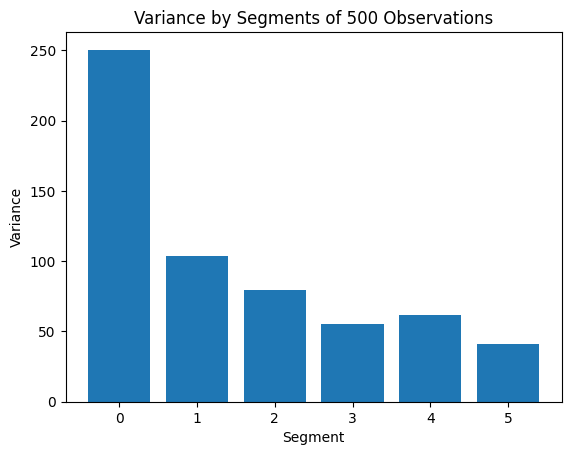

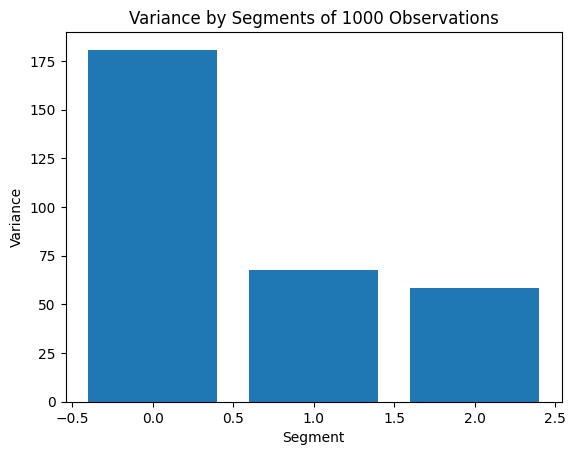

In [72]:
for size in [100, 250, 500, 1000]:
  data_ = population_smoothed
  data_segments = [data_[i:i+size] for i in range(0, len(data_), size)]
  variances = [np.var(segment) for segment in data_segments]
  plt.bar(range(0, len(variances)), variances)
  plt.title('Variance by Segments of ' + str(size) + ' Observations')
  plt.xlabel('Segment')
  plt.ylabel('Variance')
  plt.show()


## Работа с датасетом из популяций, не вышедших на плато

In [46]:
file_name = "/content/drive/MyDrive/simulations/false_plato.csv"
false_plato = pd.read_csv(file_name)

In [47]:
false_plato.head()

,dd,death_r,epochs_count,area_length_x,area_length_y,initial_pop,b,sd_b,sd_d,d,final_pop
0,0.21,2.40,3000,11,11,1,0.35,0.80,0.80,0.2,68
1,0.31,2.85,3000,25,25,1,0.65,0.50,0.95,0.4,232
2,0.41,1.95,3000,11,11,1,0.55,0.50,0.65,0.2,78
3,0.11,1.95,3000,25,25,1,0.55,0.50,0.65,0.4,380
4,0.11,1.50,3000,5,5,1,0.25,0.65,0.50,0.1,38


In [48]:
false_plato.drop(columns=["epochs_count", "initial_pop", "area_length_x"]).describe()

,dd,death_r,area_length_y,b,sd_b,sd_d,d,final_pop
count,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000
mean,0.258841,2.221925,10.855615,0.480766,0.756417,0.740642,0.234759,103.311943
std,0.106417,0.498113,5.759977,0.140284,0.166218,0.166038,0.122272,87.801424
min,0.110000,1.500000,5.000000,0.150000,0.500000,0.500000,0.100000,10.000000
25%,0.210000,1.950000,5.000000,0.350000,0.650000,0.650000,0.100000,32.000000
50%,0.210000,2.400000,11.000000,0.450000,0.800000,0.800000,0.200000,82.000000
75%,0.310000,2.850000,16.000000,0.550000,0.950000,0.950000,0.300000,142.000000
max,0.410000,2.850000,25.000000,0.860000,0.950000,0.950000,0.600000,436.000000


In [55]:
cor = false_plato.drop(columns=["epochs_count", "initial_pop", "area_length_x", "death_r"]).corr()

<Axes: >

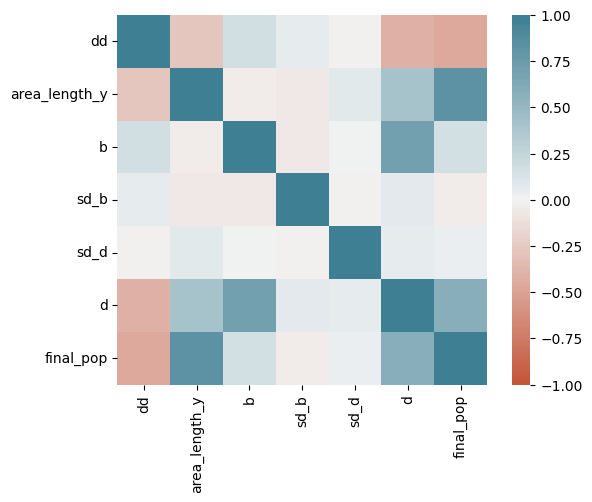

In [56]:
import seaborn as sns

sns.heatmap(
    cor, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

## Подбор порога

In [73]:
max_arr = []
sec_mx_arr = []
for n in range(len(data)):
  for size in [max(500, len(data[n]["smoothed"])//5), max(1000, len(data[n]["smoothed"])//10)]:
    data_ = data[n]["smoothed"]["pop"]
    data_segments = [data_[i:i+size] for i in range(0, len(data_), size)]
    variances = [np.var(segment) or  0.00000001 for segment in data_segments]
    mx = -1
    sec_mx = -1
    for i in range(len(variances)-2):
      if (mx < variances[i]/variances[i+1] or mx < 1/(variances[i]/variances[i+1])):
        sec_mx = mx
      mx = max(variances[i]/variances[i+1], mx)
      # для убывающих графиков
      mx = max(1/(variances[i]/variances[i+1]), mx)
    max_arr.append(mx)
    if sec_mx!=-1:
      sec_mx_arr.append(sec_mx)

In [74]:
pd.DataFrame(max_arr).describe()

,0
count,1122.000000
mean,4.536081
std,3.269154
min,1.000135
25%,2.036549
50%,3.359038
75%,6.315424
max,18.147459


In [75]:
pd.DataFrame(sec_mx_arr).describe()

,0
count,105.000000
mean,1.491864
std,0.377902
min,1.017725
25%,1.206487
50%,1.399185
75%,1.652895
max,2.980801
